This dataset consists of two distinct sets of single-band GeoTIFFs: one representing the modal vegetation type for each computed over a given era, and one representing the occurence percentage of a given vegetation type for a given era. The former is provided in the alfresco_vegetation_mode_statistic.zip archive, and the latter is provided in the alfresco_vegetation_type_percentage.zip archive. Both subdatasets are derived from the same set of ALFRESCO model runs driven by each of the following five models: GFDL-CM3, NCAR-CCSM4, MRI-CGCM3, IPSL-CM5A-LR, and GISS-E2-R. The calculation for each pixel is done over all years within the era and among all the simulations (200 replicate runs x number of years per simulation). The file naming convention for the modal dataset looks like this: alfresco_relative_vegetation_change_<start year of summary era>-<end year of summary era>_<model>_<scenario>.tif. The convention is identical for the type percentage version, but with an integer code suffix indicating the vegetation type. The mapping for integer value to vegetation type is as follows: 0: not_modeled, 1: black spruce, 2: white spruce, 3: deciduous forest, 4: shrub tundra, 5: graminoid tundra, 6: wetland tundra, 7: barren lichen moss, 8: temperate rainforest The historical runs of the ALFRESCO outputs, driven by CRU-TS, are also included in this revision. For background on ALFRESCO, please refer to the following reference: Daniel H. Mann, T. Scott Rupp, Mark A. Olson, and Paul A. Duffy. 2012. Is Alaska's Boreal Forest Now Crossing a Major Ecological Threshold? Arctic, Antarctic, and Alpine Research 44 (3), 319-331

In [ ]:
# #based on copernicus lc - this is the key
# 1: black spruce --> 1
# 2: white spruce --> 1
# 3: deciduous forest --> 3 # copernicus lc did not have deciduous forest, so using mixed forest
# 4: shrub tundra --> 12
# 5: graminoid tundra --> 12
# 6: wetland tundra --> 9 
# 7: barren lichen moss --> 18
# 8: temperate rainforest --> 3 # copernicus lc did not have temperate rainforest, so using mixed forest

In [ ]:
# SM 
# ! The vegetation types are assumed to range from 1 through 30.  The
# !   last 7 types are available to be user-defined vegetation types
# !   and vegetation snow-holding capacities.  The first 23 vegetation
# !   types, and the associated vegetation snow-holding capacities
# !   (depth, in meters), are hard-coded to be:
# !
# ! code description           veg_shc  example                    class
# !
# !  1  coniferous forest       15.00  spruce-fir/taiga/lodgepole  forest
# !  2  deciduous forest        12.00  aspen forest                forest
# !  3  mixed forest            14.00  aspen/spruce-fir/low taiga  forest
# !  4  scattered short-conifer  8.00  pinyon-juniper              forest
# !  5  clearcut conifer         4.00  stumps and regenerating     forest
# ! 
# !  6  mesic upland shrub       0.50  deeper soils, less rocky    shrub
# !  7  xeric upland shrub       0.25  rocky, windblown soils      shrub
# !  8  playa shrubland          1.00  greasewood, saltbush        shrub
# !  9  shrub wetland/riparian   1.75  willow along streams        shrub
# ! 10  erect shrub tundra       0.65  arctic shrubland            shrub
# ! 11  low shrub tundra         0.30  low to medium arctic shrubs shrub
# ! 
# ! 12  grassland rangeland      0.15  graminoids and forbs        grass
# ! 13  subalpine meadow         0.25  meadows below treeline      grass
# ! 14  tundra (non-tussock)     0.15  alpine, high arctic         grass
# ! 15  tundra (tussock)         0.20  graminoid and dwarf shrubs  grass
# ! 16  prostrate shrub tundra   0.10  graminoid dominated         grass
# ! 17  arctic gram. wetland     0.20  grassy wetlands, wet tundra grass
# ! 
# ! 18  bare                     0.01                              bare
# !
# ! 19  water/possibly frozen    0.01                              water
# ! 20  permanent snow/glacier   0.01                              water
# ! 
# ! 21  residential/urban        0.01                              human
# ! 22  tall crops               0.40  e.g., corn stubble          human
# ! 23  short crops              0.25  e.g., wheat stubble         human

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from rasterio.warp import transform
import xarray as xr
import rioxarray as rxr
import glob
import scipy

In [59]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################
# PATHS

# DOMAIN
# choose the modeling domain
domain = 'YUKO'

# path to temporary folder to store tif files from gee
TIFpath = domain + '_GEE_Downloads/'

# path to directory where you want your output .tif and .asc files
dataPath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'

# path to SM
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'

# future landcover out path
futLC_TIFFpath = dataPath+domain+'_veg_fut.tif'
futLC_ASCpath = dataPath+domain+'_veg_fut.asc'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()
    
# domain parameters
nx = domains[domain]['ncols']
ny = domains[domain]['nrows']
clsz = domains[domain]['cellsize']
xll = domains[domain]['xll']
yll = domains[domain]['yll']
st_dt = '2011-10-01'
#########################################################################

In [3]:
# open landcover copernicus
LCfile = dataPath+domain+'_veg.tif'
lcsm = rxr.open_rasterio(LCfile)
# lc to numpy array
LC = np.squeeze(lcsm.values)
# convert to dataset
lc = lcsm.to_dataset('band')
lc = lc.rename({1:'lc'})

In [4]:
# open landcover alfresco
path = '/nfs/attic/dfh/2020_NPRB/data/veg_change/alfresco_relative_vegetation_change_1950-2008_historical.tif'
lcmod = rxr.open_rasterio(path)
lcmod

<xarray.DataArray (band: 1, y: 2100, x: 3650)>
[7665000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.725e+06 -1.724e+06 ... 1.923e+06 1.924e+06
  * y            (y) float64 2.544e+06 2.543e+06 ... 4.459e+05 4.449e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
# reproject to match old landcover data
hlc = lcmod.rio.reproject_match(lcsm)
# numpy array
HLC = np.squeeze(hlc.values)
# add to xarray dataset
lc['hlc_orig']=(['y','x'],np.squeeze(hlc.values))

In [6]:
# future landcover
path = '/nfs/attic/dfh/2020_NPRB/data/veg_change/alfresco_relative_vegetation_change_2070-2099*.tif'
list_of_files = sorted( filter( os.path.isfile,glob.glob(path) ) )
flcs = []
for file in list_of_files:
    #open .tif
    data = rxr.open_rasterio(file)
    #reproject to match domain
    data_reproj = data.rio.reproject_match(lcsm)
    flcs.append(data_reproj.values)
# concatenate arrays    
flc_cat = np.concatenate(flcs)
# find the mode
# dim 0 = mode, dim 1 = count
lcmode = scipy.stats.mode(flc_cat,axis=0,keepdims=False)
# numpy array
FLC = lcmode[0]
# add to dataset
lc['flc_orig']= (['y','x'],lcmode[0])
lc

<xarray.Dataset>
Dimensions:      (y: 527, x: 863)
Coordinates:
  * x            (x) float64 -7.262e+05 -7.238e+05 ... 1.426e+06 1.429e+06
  * y            (y) float64 2.301e+06 2.299e+06 ... 9.888e+05 9.862e+05
    spatial_ref  int64 0
Data variables:
    lc           (y, x) uint8 24 24 24 24 24 24 24 24 ... 12 1 18 18 20 20 20 20
    hlc_orig     (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
    flc_orig     (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [7]:
def veg2sm(indata):
    #change modeled veg to sm categories
    #reclassify white spruce forest & black spruce forest to conifer forest
    update = np.where(indata == 2,1,indata)
    # reclassify shrub tundra & graminoid tundra as grassland/rangeland
    update = np.where(indata == 4,12,update)
    update = np.where(indata == 5,12,update)
    # reclassify wetland tundra as shrub wetland/riparian
    update = np.where(indata == 6,9,update)
    # reclassify barren lichen to bare
    update = np.where(indata == 7,18,update)
    # reclassify temperate rainforest to mixed forest
    update = np.where(indata == 8,3,update)
    return update
lc['hlc']=(['y','x'],veg2sm(HLC))
lc['flc']=(['y','x'],veg2sm(FLC))
lc

<xarray.Dataset>
Dimensions:      (y: 527, x: 863)
Coordinates:
  * x            (x) float64 -7.262e+05 -7.238e+05 ... 1.426e+06 1.429e+06
  * y            (y) float64 2.301e+06 2.299e+06 ... 9.888e+05 9.862e+05
    spatial_ref  int64 0
Data variables:
    lc           (y, x) uint8 24 24 24 24 24 24 24 24 ... 12 1 18 18 20 20 20 20
    hlc_orig     (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
    flc_orig     (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
    hlc          (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
    flc          (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [11]:
# replace all vegetation lc that changed from past to future with the future value
# everywhere else will remain the copernicus lc 
flcmod = np.where(HLC!=FLC,FLC,LC)
# keep all non-vegetation lc classes 
FLCMOD = np.where((LC==19)|(LC==20)|(LC==21)|(LC==22)|(LC==24),LC,flcmod)
# add to ds
lc['flc_mod']= (['y','x'],FLCMOD)

In [21]:
# save out future lc as .tif
lc.flc_mod.rio.to_raster(futLC_TIFFpath)

In [54]:
# save out future lc as .asc
# open .tif
futlc = xr.open_rasterio(futLC_TIFFpath)
# save out future lc as .asc
head = "ncols\t"+str(futlc.shape[2])+"\n" \
    "nrows\t"+str(futlc.shape[1])+"\n" \
    "xllcorner\t"+str(int(min(futlc.x.values)-futlc.res[0]/2))+"\n" \
    "yllcorner\t"+str(int(min(futlc.y.values)-futlc.res[0]/2))+"\n" \
    "cellsize\t"+str(int(futlc.res[0]))+"\n" \
    "NODATA_value\t-9999" 
#save lc
np.savetxt(futLC_ASCpath, np.squeeze(futlc.values), fmt='%d', header = head,comments='')
    

/tmp/ipykernel_267531/2203735198.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  futlc = xr.open_rasterio(futLC_TIFFpath)


In [60]:
# save out modified topoveg .gdat
# Path to dem and veg files
dem_fname = domain+'_demHF.asc'
veg_fname = domain+'_veg_fut.asc'
demveg_fname = 'dem_veg_'+domain+'_fut.gdat'
demveg_ctl = 'dem_veg_'+domain+'_fut.ctl'
topoveg_path = SMpath+'topo_vege/'

# Path to the flow directions fortran file for editing
mkgdat_fortran = dataPath+'mk_grads_from_ascii_topoveg.f'
print(mkgdat_fortran)

# Function to edit fortran files
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

# edit the .f file for the domain
replace_line(mkgdat_fortran, 7, '      parameter (nx='+nx+',ny='+ny+')\n')
replace_line(mkgdat_fortran, 12, '      open (21,file=\''+dem_fname+'\')\n')
replace_line(mkgdat_fortran, 13, '      open (22,file=\''+veg_fname+'\')\n')
replace_line(mkgdat_fortran, 26, '      open (31,file=\''+demveg_fname+'\',\n')

# execute the function
# Use line magic to change directories to the file locations
# Run the fortran script and save the output
%cd $dataPath
!gfortran mk_grads_from_ascii_topoveg.f
!./a.out

# write out corresponding .ctl file
ctl_list = ['DSET ^'+demveg_fname,
            'TITLE xxxxxxxxxxxxxxxxxxxxxxxxx',
            'UNDEF  -9999.0',
            'XDEF   '+nx+' LINEAR '+xll+' '+clsz,
            'YDEF   '+ny+' LINEAR '+yll+' '+clsz,
            'ZDEF    1 LEVELS 1',
            'TDEF    1 LINEAR 00Z01sep2001 1dy',
            'VARS    2',
            'topo    0  0 topo(m)',
            'veg     0  0 veg type',
            'ENDVARS']
with open(demveg_ctl, 'w') as f:
    f.write('\n'.join(ctl_list))
    
# move files to modeling space 
!mv $demveg_fname $topoveg_path
!mv $demveg_ctl $topoveg_path

/nfs/attic/dfh/2020_NPRB/data/SMinputs/YUKO/mk_grads_from_ascii_topoveg.f
/nfs/attic/dfh/2020_NPRB/data/SMinputs/YUKO


Text(0.5, 1.0, 'alfresco future mod')

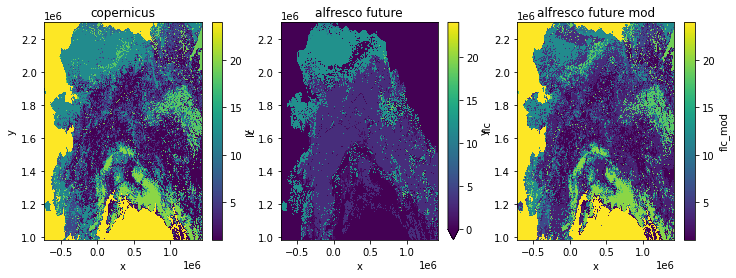

In [14]:
# plots of lc change
fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=[12,4])
lc.lc.plot(ax=ax)
ax.set_title('copernicus')
lc.flc.plot(ax=ax1,vmin=0,vmax=24)
ax1.set_title('alfresco future')
lc.flc_mod.plot(ax=ax2)
ax2.set_title('alfresco future mod')

Text(0.5, 1.0, 'future')

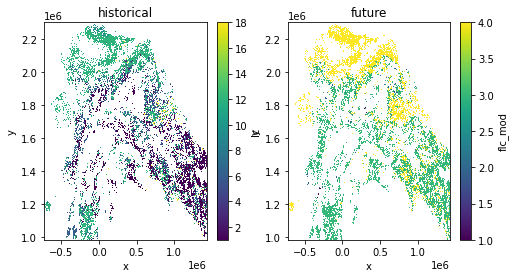

In [19]:
# where lc changed
fig, (ax, ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc!=lc.flc_mod).plot(ax=ax)
ax.set_title('historical')
lc.flc_mod.where(lc.lc!=lc.flc_mod).plot(ax=ax1)
ax1.set_title('future')


Text(0.5, 1.0, 'alfresco future')

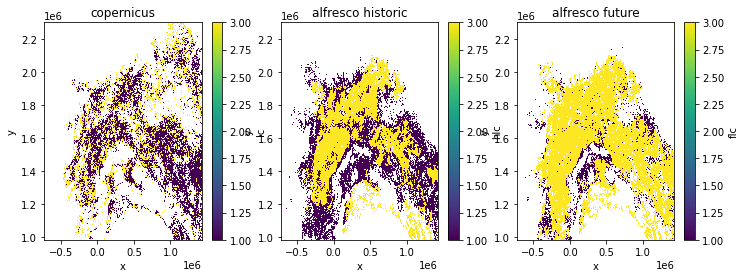

In [32]:
# using reclassified alfresco lc classes to align with sm
fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=[12,4])
lc.lc.where((lc.lc==1)|(lc.lc==3)).plot(ax=ax)
ax.set_title('copernicus')
lc.hlc.where((lc.hlc==1)|(lc.hlc==3)).plot(ax=ax1)
ax1.set_title('alfresco historic')
lc.flc.where((lc.flc==1)|(lc.flc==3)).plot(ax=ax2)
ax2.set_title('alfresco future')

Text(0.5, 1.0, 'alfresco future')

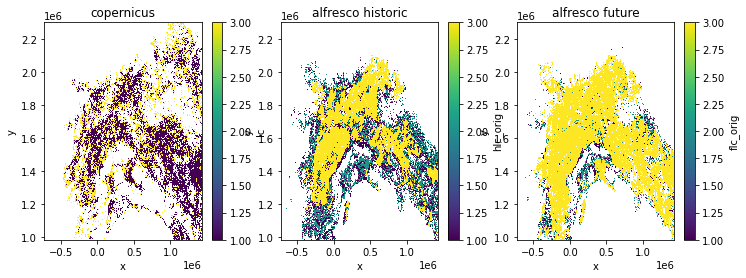

In [33]:
# using original alfresco lc classes
fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=[12,4])
lc.lc.where((lc.lc==1)|(lc.lc==3)).plot(ax=ax)
ax.set_title('copernicus')
lc.hlc_orig.where((lc.hlc_orig==1)|(lc.hlc_orig==2)|(lc.hlc_orig==3)).plot(ax=ax1)
ax1.set_title('alfresco historic')
lc.flc_orig.where((lc.flc_orig==1)|(lc.flc_orig==2)|(lc.flc_orig==3)).plot(ax=ax2)
ax2.set_title('alfresco future')

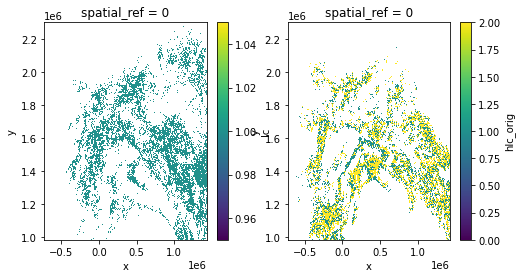

In [19]:
# conifer forest | white spruce forest & black spruce forest
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc==1).plot(ax=ax)
lc.hlc_orig.where((lc.hlc_orig==1)|(lc.hlc_orig==2)).plot(ax=ax1,vmin=0)

In [23]:
smcount = lc.lc.where(lc.lc==1).count()
smocount = lc.lc.where((lc.lc==1)&(lc.hlc_orig==1)).count()
smocount1 = lc.lc.where((lc.lc==1)&(lc.hlc_orig==2)).count()
(smocount+smocount1)/smcount

<xarray.DataArray 'lc' ()>
array(0.37205799)
Coordinates:
    spatial_ref  int64 0

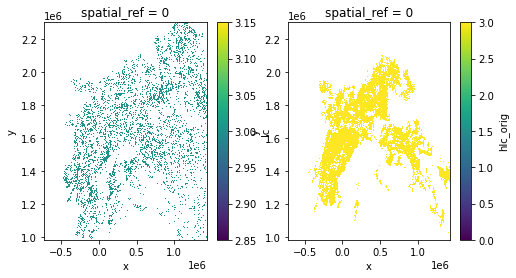

In [25]:
# mixed forest | deciduous forest
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc==3).plot(ax=ax)
lc.hlc_orig.where(lc.hlc_orig==3).plot(ax=ax1,vmin=0)

(array(250), array(64739))

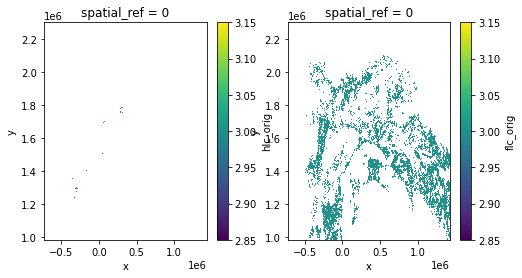

In [26]:
# deciduous forest change
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
#past deciduous forest
d_past=lc.hlc_orig.where(lc.hlc_orig==3)
#past deciduous forest
d_fut=lc.flc_orig.where(lc.flc_orig==3)
#where past deciduous forest was lost 
d_past.where((d_past==3)&(d_fut.isnull())).plot(ax=ax)
#where futre deciduous forest was gained
d_fut.where((d_fut==3)&(d_past.isnull())).plot(ax=ax1)
d_past.where((d_past==3)&(d_fut.isnull())).count().values,d_fut.where((d_fut==3)&(d_past.isnull())).count().values

In [29]:
d_past.where((d_past==3)&(d_fut.isnull())).count().values,d_fut.where((d_fut==3)&(d_past.isnull())).count().values

(array(250), array(64739))

In [31]:
smcount = lc.lc.where(lc.lc==3).count()
smocount = lc.lc.where((lc.lc==3)&(lc.hlc_orig==3)).count()
smocount/smcount

<xarray.DataArray 'lc' ()>
array(0.35584962)
Coordinates:
    spatial_ref  int64 0

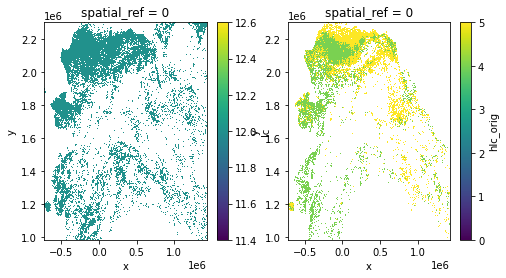

In [34]:
# grassland/rangeland | shrub tundra & graminoid tundra
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc==12).plot(ax=ax)
lc.hlc_orig.where((lc.hlc_orig==4)|(lc.hlc_orig==5)).plot(ax=ax1,vmin=0)

In [36]:
smcount = lc.lc.where(lc.lc==12).count()
smocount = lc.lc.where((lc.lc==12)&(lc.hlc_orig==4)).count()
smocount1 = lc.lc.where((lc.lc==12)&(lc.hlc_orig==5)).count()
(smocount+smocount1)/smcount

<xarray.DataArray 'lc' ()>
array(0.54846282)
Coordinates:
    spatial_ref  int64 0

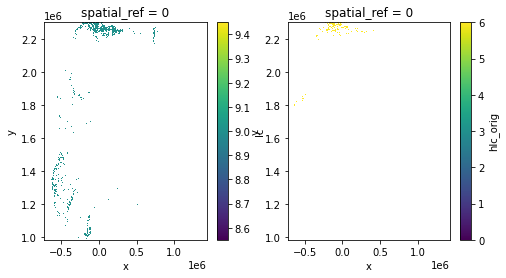

In [37]:
# shrub wetland/riparian | wetland tundra
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc==9).plot(ax=ax)
lc.hlc_orig.where(lc.hlc_orig==6).plot(ax=ax1,vmin=0)

In [38]:
smcount = lc.lc.where(lc.lc==9).count()
smocount = lc.lc.where((lc.lc==9)&(lc.hlc_orig==6)).count()
smocount/smcount

<xarray.DataArray 'lc' ()>
array(0.11581966)
Coordinates:
    spatial_ref  int64 0

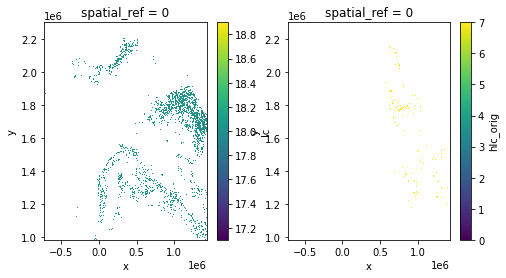

In [39]:
# bare | barren lichen
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc==18).plot(ax=ax)
lc.hlc_orig.where(lc.hlc_orig==7).plot(ax=ax1,vmin=0)

In [41]:
smcount = lc.lc.where(lc.lc==18).count()
smocount = lc.lc.where((lc.lc==18)&(lc.hlc_orig==7)).count()
smocount/smcount

<xarray.DataArray 'lc' ()>
array(0.03436179)
Coordinates:
    spatial_ref  int64 0

In [34]:
np.unique(lc.lc.values)

array([ 1,  2,  3,  4,  6,  9, 12, 18, 19, 20, 21, 22, 24], dtype=uint8)

In [30]:
np.unique(lc.hlc_orig.values)

array([-9.999e+03,  0.000e+00,  1.000e+00,  2.000e+00,  3.000e+00,
        4.000e+00,  5.000e+00,  6.000e+00,  7.000e+00,  8.000e+00],
      dtype=float32)